In [115]:
##          DATA SHAPE DEFINITION           ##

import numpy as np

# Define the parameters for the data shape
num_handsigns = 4
videos_per_handsign = 132
frames_per_video = 20
num_landmarks = 51
num_coordinates = 3

# Hand sign mapping
handsign_names = {
    0: "nada detectado",
    1: "Opaco",
    2: "Rojo",
    3: "Verde",
    4: "Amarillo",
    5: "Brillante",
    6: "Celeste",
    7: "Colores",
    8: "Rosa",
    9: "Mujer",
    10: "Enemigo"
} 

# Generate dummy data
data = [np.random.rand(videos_per_handsign, frames_per_video, num_landmarks, num_coordinates) for _ in range(num_handsigns)]

# Convert the list to a numpy array with shape (num_handsigns, videos_per_handsign, frames_per_video, num_landmarks, num_coordinates)
data_array = np.array(data)

# Save the data array to a .npy file
np.save('handsigns_data.npy', data_array)

In [116]:
##          PROCESS VIDEO DATASET FUNC DEFINITIONS         ##
import cv2
import mediapipe as mp
import numpy as np
import os
from tqdm import tqdm

def extract_landmarks(hands_results, pose_results):
    landmarks = []
    
    try:
        nose_landmark = pose_results.pose_landmarks.landmark[0]     #all landmarks are put relative to the nose landmark
    except:
        class nose_landmark:
            x = 0
            y = 0
            z = 0
        nose_landmark = nose_landmark()
    
    
    # Extract left hand landmarks (21 landmarks) 
    if hands_results.multi_hand_landmarks and len(hands_results.multi_hand_landmarks) > 0:
        landmarks.extend([(lm.x-nose_landmark.x, lm.y-nose_landmark.y, lm.z-nose_landmark.z) for lm in hands_results.multi_hand_landmarks[0].landmark])
    else:
        landmarks.extend([(0, 0, 0)] * 21)
    
    # Extract right hand landmarks (21 landmarks)
    if hands_results.multi_hand_landmarks and len(hands_results.multi_hand_landmarks) > 1:
        landmarks.extend([(lm.x-nose_landmark.x, lm.y-nose_landmark.y, lm.z-nose_landmark.z) for lm in hands_results.multi_hand_landmarks[1].landmark])
    else:
        landmarks.extend([(0, 0, 0)] * 21)
    
    # Extract selected body landmarks (9 landmarks)
    selected_body_landmarks = [0, 11, 12, 13, 14, 15, 16, 23, 24]  # Landmarks for nose, arms, and shoulders
    if pose_results.pose_landmarks:
        for idx in selected_body_landmarks:
            lm = pose_results.pose_landmarks.landmark[idx]
            landmarks.append((lm.x-nose_landmark.x, lm.y-nose_landmark.y, lm.z-nose_landmark.z))
    else:
        landmarks.extend([(0, 0, 0)] * 9)
    
    return np.array(landmarks)

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    mp_hands = mp.solutions.hands
    mp_pose = mp.solutions.pose

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, total_frames - 1, frames_per_video, dtype=int)
    frame_set = set(indices)
    frame_count = 0
    
    with mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5) as hands, \
         mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        
        while cap.isOpened() and len(frames) < frames_per_video:
            ret, frame = cap.read()
            if not ret:
                break
            
            if frame_count in frame_set:
                # Convert the BGR image to RGB
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                # Process the image and extract landmarks
                hands_results = hands.process(image)
                pose_results = pose.process(image)
                
                # Extract landmarks
                landmarks = extract_landmarks(hands_results, pose_results)
                
                frames.append(landmarks)
            
            frame_count += 1
    
    cap.release()
    
    # Pad if we don't have enough frames
    if len(frames) < frames_per_video:
        frames.extend([np.zeros((51, 3))] * (frames_per_video - len(frames)))
    
    return np.array(frames)

def process_dataset(root_path):
    data = []
    
    for handsign in tqdm(range(num_handsigns), desc="Processing handsigns"):
        handsign_path = os.path.join(root_path, f"handsign_{handsign+1}")  # Changed to match your folder naming
        if not os.path.exists(handsign_path):
            print(f"Warning: Directory {handsign_path} does not exist. Skipping.")
            data.append(np.zeros((videos_per_handsign, frames_per_video, 51, 3)))  # 51 landmarks total
            continue
        
        videos = [f for f in os.listdir(handsign_path) if f.endswith(('.mp4', '.avi', '.mov'))]
        videos = videos[:videos_per_handsign]  # Limit to videos_per_handsign
        
        handsign_data = []
        for video in tqdm(videos, desc=f"Processing videos for handsign {handsign}", leave=False):
            video_path = os.path.join(handsign_path, video)
            video_data = process_video(video_path)
            handsign_data.append(video_data)
        
        # Pad if we don't have enough videos
        if len(handsign_data) < videos_per_handsign:
            handsign_data.extend([np.zeros((frames_per_video, 51, 3))] * (videos_per_handsign - len(handsign_data)))
        
        data.append(np.array(handsign_data))
    
    return np.array(data)


In [117]:
##          PROCESS VIDEOS DATASET FUNC CALLING         ##

if __name__ == "__main__":
    root_path = "Test10Signs_DatasetCut"  # Replace with your dataset root path
    
    data_array = process_dataset(root_path)
    
    # Save the data array to a .npy file
    np.save('handsigns_data.npy', data_array)
    print("Data saved to handsigns_data.npy")

Processing handsigns: 100%|██████████| 4/4 [15:37<00:00, 234.47s/it]               

Data saved to handsigns_data.npy


In [125]:
##          MODEL DEFINITION            ##
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Reshape input to (frames_per_video, num_landmarks * num_coordinates)
new_input_shape = (frames_per_video, num_landmarks * num_coordinates)

model = Sequential([
    # Reshape layer
    Reshape((frames_per_video, num_landmarks * num_coordinates), input_shape=(frames_per_video, num_landmarks, num_coordinates)),
    
    # LSTM layers with Dropout and Batch Normalization to reduce overfitting
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    Dropout(0.7),
    
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    Dropout(0.7),
    
    # Fully connected layer
    Dense(128, activation='relu', kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    Dropout(0.7),
    
    # Output layer for multi-class classification
    Dense(num_handsigns, activation='softmax')  # Softmax for multi-class classification
])

# Specify a learning rate
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model.summary() # Uncomment if you want to see the model summary


In [127]:
##          DATA PREPROCESSING FOR TRAINING            ##
from sklearn.model_selection import train_test_split
import shutil

# Load the data from the .npy file
shutil.copy('handsigns_data.npy', 'copy_handsigns_data.npy')
data_array = np.load('copy_handsigns_data.npy')



# X remains unchanged
X = data_array 

# Create labels for each handsign (0 to num_handsigns-1)
# This creates a label for each hand sign, repeated for each video
y = np.repeat(np.arange(num_handsigns), videos_per_handsign)
y = y.reshape(num_handsigns, videos_per_handsign)

# Initialize lists to hold training and validation data
X_train_list = []
X_val_list = []
y_train_list = []
y_val_list = []

# Split videos and labels for each handsign
for handsign_index in range(num_handsigns):
    # Split the videos within each handsign
    train_indices, val_indices = train_test_split(
        np.arange(videos_per_handsign), 
        test_size=0.2, 
        random_state=42
    )
    
    # Select training and validation data for this handsign
    X_train_list.append(data_array[handsign_index, train_indices])
    X_val_list.append(data_array[handsign_index, val_indices])
    
    # Select corresponding labels
    y_train_list.append(y[handsign_index, train_indices])
    y_val_list.append(y[handsign_index, val_indices])

# Concatenate lists to form the final training and validation sets
X_train = np.concatenate(X_train_list, axis=0)
X_val = np.concatenate(X_val_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)

# Reshape X_train and X_val to fit the model's expected input shape
X_train = X_train.reshape(-1, frames_per_video, num_landmarks, num_coordinates)
X_val = X_val.reshape(-1, frames_per_video, num_landmarks, num_coordinates)

# Flatten y_train and y_val
y_train = y_train.flatten()
y_val = y_val.flatten()

Epoch 1/150
11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2831 - loss: 10.1582
Epoch 1: val_loss improved from inf to 8.35968, saving model to best_handsigns_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.2894 - loss: 10.0674 - val_accuracy: 0.4722 - val_loss: 8.3597 - learning_rate: 0.0010
Epoch 2/150
10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3661 - loss: 9.2239
Epoch 2: val_loss improved from 8.35968 to 7.92040, saving model to best_handsigns_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3767 - loss: 9.1418 - val_accuracy: 0.6111 - val_loss: 7.9204 - learning_rate: 0.0010
Epoch 3/150
11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4275 - loss: 8.3368
Epoch 3: val_loss improved from 7.92040 to 7.51694, saving model to best_handsigns_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4294 - loss: 8.3272 - val_accuracy: 0.5278 - val_loss: 7.5169 - learning_rate: 0.0010
Epoch 4/150
12/14 ━━━━━━━━━━━━━━━━━━━━ 

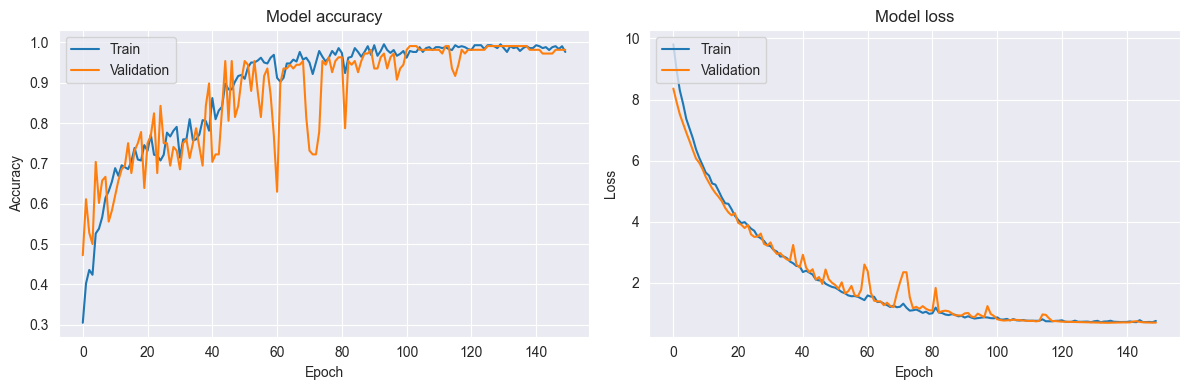

In [128]:
##          MODEL TRAINING          ##
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callback helpers for model training #
# Early stopping to stop training when validation loss stops improving
# Model checkpointing to save the best model during training
# Reduce learning rate when a metric has stopped improving

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  
checkpoint = ModelCheckpoint('best_handsigns_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)  

# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val), 
    callbacks=[checkpoint, reduce_lr]
)


# Save the trained model
model.save('handsigns_model.h5')

# Optionally, save the training history
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
    

    
##          TRAINING HISTORY ANALYSIS           ##
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# If you want to save the plot instead of displaying it:
# plt.savefig('training_history.png')

In [130]:
##          SINGLE VIDEO PREDICTION TEST         ##
def predict_handsign(video_path, model):
    # Process the video to extract landmarks
    video_data = process_video(video_path)
    
    # Reshape the data to match the model input shape (add batch dimension for a single video)
    video_data = video_data.reshape(1, frames_per_video, num_landmarks, num_coordinates)
        # Make the prediction
    prediction = model.predict(video_data)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]
    
    return predicted_class, confidence  


if __name__ == "__main__":
    # Load the trained model
    model = tf.keras.models.load_model('best_handsigns_model.keras')
    
    test_directory = "Model testing videos"
    for video_file in os.listdir(test_directory):
        if video_file.endswith(('.mp4', '.avi', '.mov')):
            video_path = os.path.join(test_directory, video_file)
            predicted_class, confidence = predict_handsign(video_path, model)
            
            # Get hand sign name
            predicted_handsign = handsign_names.get(predicted_class, f"HandSign_{predicted_class}")
            
            # Apply confidence threshold
            if confidence < 0.7:
                predicted_handsign = "Inseguro ("+predicted_handsign+")"
                
            print(f"Video: {video_file}")
            print(f"Predicted Hand Sign: {predicted_handsign}")
            print(f"Confidence: {confidence:.2f}")
            print("--------------------")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Video: noInfo_0.mp4
Predicted Hand Sign: Opaco
Confidence: 1.00
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Video: opaco_0.mp4
Predicted Hand Sign: Opaco
Confidence: 0.84
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Video: opaco_1.mp4
Predicted Hand Sign: Inseguro (Rojo)
Confidence: 0.65
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Video: opaco_2.mp4
Predicted Hand Sign: Opaco
Confidence: 0.99
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Video: opaco_3.mp4
Predicted Hand Sign: nada detectado
Confidence: 0.97
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Video: opaco_4_espejado.mp4
Predicted Hand Sign: Rojo
Confidence: 0.84
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Video: opaco_5.mp4
Predicted Hand Sign: Opaco
Confidence: 1.00
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Video: rojo_0.mp4
Predicted Hand Sign: Inseguro (Rojo)
Confidence: 0.61
-------

In [132]:
##          CONTINUOUS PREDICTION WITH SLIDING WINDOW           ##

import collections
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('best_handsigns_model.keras')

# Initialize Mediapipe solutions outside the loop for efficiency
mp_hands = mp.solutions.hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
mp_pose = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Open webcam feed
cap = cv2.VideoCapture(0)

# Sliding window buffer for frames
frame_buffer = collections.deque(maxlen=frames_per_video)

# To smooth predictions, keep track of recent predictions
prediction_buffer = collections.deque(maxlen=5)  # Adjust window size as needed

# Store the last prediction
last_prediction = "No Prediction"
last_confidence = 0.0

# Limit prediction frequency
frame_skip = 1  # Process every Nth frame
frame_count = 0

# Draw landmarks on the frame
def draw_landmarks(frame, landmarks):
    """Draw landmarks on the frame."""
    for i, (x, y, z) in enumerate(landmarks):
        h, w, _ = frame.shape
        x = int(x * w + 325)
        y = int(y * h + 250)
        
        if i < 21:  # Left hand landmarks
            color = (0, 255, 0)
        elif i < 42:  # Right hand landmarks
            color = (0, 0, 255)
        else:  # Body landmarks
            color = (255, 0, 0)
        
        cv2.circle(frame, (x, y), 5, color, -1)

# Process a frame to extract landmarks
def process_frame(frame):
    """Process a single frame to extract landmarks."""
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Process the image to extract hands and pose landmarks
    hands_results = mp_hands.process(image)
    pose_results = mp_pose.process(image)
    
    # Extract landmarks (use your extract_landmarks function)
    landmarks = extract_landmarks(hands_results, pose_results)
    
    return landmarks

# Make a prediction based on the buffer
def predict_handsign(buffer):
    """Make a prediction based on a buffer of frames."""
    video_data = np.array(buffer)
    video_data = video_data.reshape(1, frames_per_video, num_landmarks, num_coordinates)
    
    # Make prediction
    prediction = model.predict(video_data, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]
    
    return predicted_class, confidence

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.flip(frame, 1)
    
    # Increment the frame count
    frame_count += 1
    
    # Process every nth frame to reduce load
    if frame_count % frame_skip == 0:
        # Process the current frame and extract landmarks
        landmarks = process_frame(frame)
        
        # Add the landmarks to the frame buffer
        frame_buffer.append(landmarks)
        
        # Draw the landmarks on the frame
        draw_landmarks(frame, landmarks)
        
        # Once the buffer is full, make a prediction using the sliding window
        if len(frame_buffer) == frames_per_video:
            predicted_class, confidence = predict_handsign(frame_buffer)
            predicted_handsign = handsign_names.get(predicted_class, f"HandSign_{predicted_class}")
            
            # Update the last prediction
            last_prediction = predicted_handsign
            last_confidence = confidence
            
            # Store prediction and confidence in the buffer for smoothing
            prediction_buffer.append((predicted_class, confidence))
            
            # Average the last N predictions to smooth the output
            avg_pred_class = np.argmax(np.bincount([p[0] for p in prediction_buffer]))
            avg_confidence = np.mean([p[1] for p in prediction_buffer if p[0] == avg_pred_class])
            
            if avg_confidence > 0.7:
                last_prediction = handsign_names.get(avg_pred_class, f"HandSign_{avg_pred_class}")
                last_confidence = avg_confidence
            else:
                last_prediction = "nada detectado"
                last_confidence = avg_confidence
    
    # Display the last prediction on the frame
    cv2.putText(frame, f"Predicted: {last_prediction}, Conf: {last_confidence:.2f}", 
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Show the frame with landmarks and the last prediction
    cv2.imshow('Handsign Prediction', frame)
    
    # Exit if the user presses 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()

# Release MediaPipe resources
mp_hands.close()
mp_pose.close()


In [ ]:

##          MODEL TESTING          ##

import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess_test_data(test_data_path):
    # Reuse the process_dataset function
    test_data = process_dataset(test_data_path)
    
    # Reshape the data to match the model input shape
    X_test = test_data.reshape(-1, frames_per_video, num_landmarks, num_coordinates)
    y_test = np.repeat(np.arange(num_handsigns), videos_per_handsign)
    
    return X_test, y_test

def evaluate_model(model, X_test, y_test):
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes))
    
    return y_pred_classes

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def visualize_misclassifications(X_test, y_test, y_pred, num_samples=5):
    misclassified = np.where(y_test != y_pred)[0]
    np.random.shuffle(misclassified)
    
    for i in range(min(num_samples, len(misclassified))):
        idx = misclassified[i]
        plt.figure(figsize=(10, 5))
        
        # Plot a representation of the hand sign (e.g., first frame landmarks)
        plt.subplot(1, 2, 1)
        plt.scatter(X_test[idx, 0, :, 0], X_test[idx, 0, :, 1])
        plt.title(f"True: {y_test[idx]}, Predicted: {y_pred[idx]}")
        plt.xlabel("X coordinate")
        plt.ylabel("Y coordinate")
        
        # Plot the confidence scores for each class
        plt.subplot(1, 2, 2)
        confidence_scores = model.predict(X_test[idx:idx+1])[0]
        plt.bar(range(num_handsigns), confidence_scores)
        plt.title("Confidence Scores")
        plt.xlabel("Hand Sign Class")
        plt.ylabel("Confidence")
        
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    # Load the trained model
    model = tf.keras.models.load_model('handsigns_model.h5')
    
    # Load and preprocess test data
    test_data_path = "Model testing videos"  # Replace with your test dataset path
    X_test, y_test = load_and_preprocess_test_data(test_data_path)
    
    # Evaluate the model
    y_pred = evaluate_model(model, X_test, y_test)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred)
    
    # Visualize some misclassifications
    visualize_misclassifications(X_test, y_test, y_pred)